In [1]:
%cd ..

/home/akajal/DiVAE


In [2]:
import os
import sys

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from models.rbm.chimeraRBM import ChimeraRBM
from models.rbm.rbm import RBM
from models.samplers.pcd import PCD

[18:25:34.323] INFO   DiVAE                                             Willkommen!
[18:25:34.324] INFO   DiVAE                                             Loading configuration.


In [5]:
def sample_energies(rbm, rbm_vis, rbm_hid):
    """
    Compute the energies of samples produced by the RBM

    Returns:
        rbm_energy_exp : -vis^T W hid - a^T hid - b^T vis
    """
    # Broadcast W to (pcd_batchSize * nVis * nHid)
    w, vbias, hbias = rbm.weights, rbm.visible_bias, rbm.hidden_bias
    w = w + torch.zeros((rbm_vis.size(0),) + w.size(), device=rbm_vis.device)
    vbias = vbias.to(rbm_vis.device)
    hbias = hbias.to(rbm_hid.device)

    # Prepare H, V for torch.matmul()
    # Change V.size() from (batchSize * nVis) to (batchSize * 1 * nVis)
    vis = rbm_vis.unsqueeze(2).permute(0, 2, 1)
    # Change H.size() from (batchSize * nHid) to (batchSize * nHid * 1)
    hid = rbm_hid.unsqueeze(2)

    batch_energies = (- torch.matmul(vis, torch.matmul(w, hid)).reshape(-1) 
                      - torch.matmul(rbm_vis, vbias)
                      - torch.matmul(rbm_hid, hbias))

    return batch_energies

In [6]:
def plot_sample_energies(energies):
    """
    Plot the energies of the samples produced by the histograms        
    """
    fig, ax = plt.subplots(figsize=(40, 16))
    
    ax.hist(energies, bins=100, density=True)
    
    ax.set_xlabel("Energy", fontsize=60)
    ax.set_ylabel("Frequency", fontsize=60)
    
    ax.tick_params(axis='both', which='major', labelsize=60)
    
    plt.show()
    plt.close()

In [39]:
_NUM_NODES = 10

In [40]:
crbm = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
rbm = RBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)

In [41]:
crbm_weights = crbm.weights.flatten()
crbm_weights = crbm_weights[crbm_weights.nonzero()]

In [42]:
print(crbm_weights)

tensor([[-0.0503],
        [-0.7895],
        [ 1.2393],
        [-0.7539],
        [ 2.2964],
        [-0.2381],
        [ 0.3050],
        [ 0.2956],
        [-1.7101],
        [ 0.8732],
        [-0.7782],
        [ 0.7521],
        [-0.7577],
        [ 0.6496],
        [-1.0881],
        [ 0.1899],
        [-1.5187],
        [-0.4985],
        [-0.2215],
        [-0.5399],
        [-0.7062],
        [-0.6142],
        [ 0.9013],
        [ 1.2523],
        [ 0.0094],
        [-0.8214],
        [ 0.5177],
        [-0.5939],
        [ 0.0710],
        [ 0.4220],
        [ 0.0787],
        [ 1.0956],
        [-0.9314],
        [-0.4757],
        [-0.2946],
        [ 0.6635],
        [ 1.3600],
        [ 0.2578],
        [-0.0357],
        [ 0.1337],
        [-1.6915],
        [-0.8805]], grad_fn=<IndexBackward0>)


In [43]:
def binarize(val):
    return format(val, 'b').zfill(_NUM_NODES*2)

In [44]:
vbinarize = np.vectorize(binarize)

In [45]:
config_int = np.arange(0, (2**20))
print(config_int.shape)

(1048576,)


In [46]:
config_bin = vbinarize(config_int)

In [47]:
config_bin.shape

(1048576,)

In [48]:
config = np.zeros((config_bin.shape[0], _NUM_NODES*2))

In [49]:
config

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
for i in range(config_bin.shape[0]):
    config[i] = list(config_bin[i])

In [51]:
config

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [52]:
config_tensor = torch.from_numpy(config).float()

In [53]:
config_tensor.shape

torch.Size([1048576, 20])

In [54]:
rbm_energies = sample_energies(rbm, config_tensor[:, :_NUM_NODES], config_tensor[:, _NUM_NODES:]).detach().cpu().numpy()
crbm_energies = sample_energies(crbm, config_tensor[:, :_NUM_NODES], config_tensor[:, _NUM_NODES:]).detach().cpu().numpy()

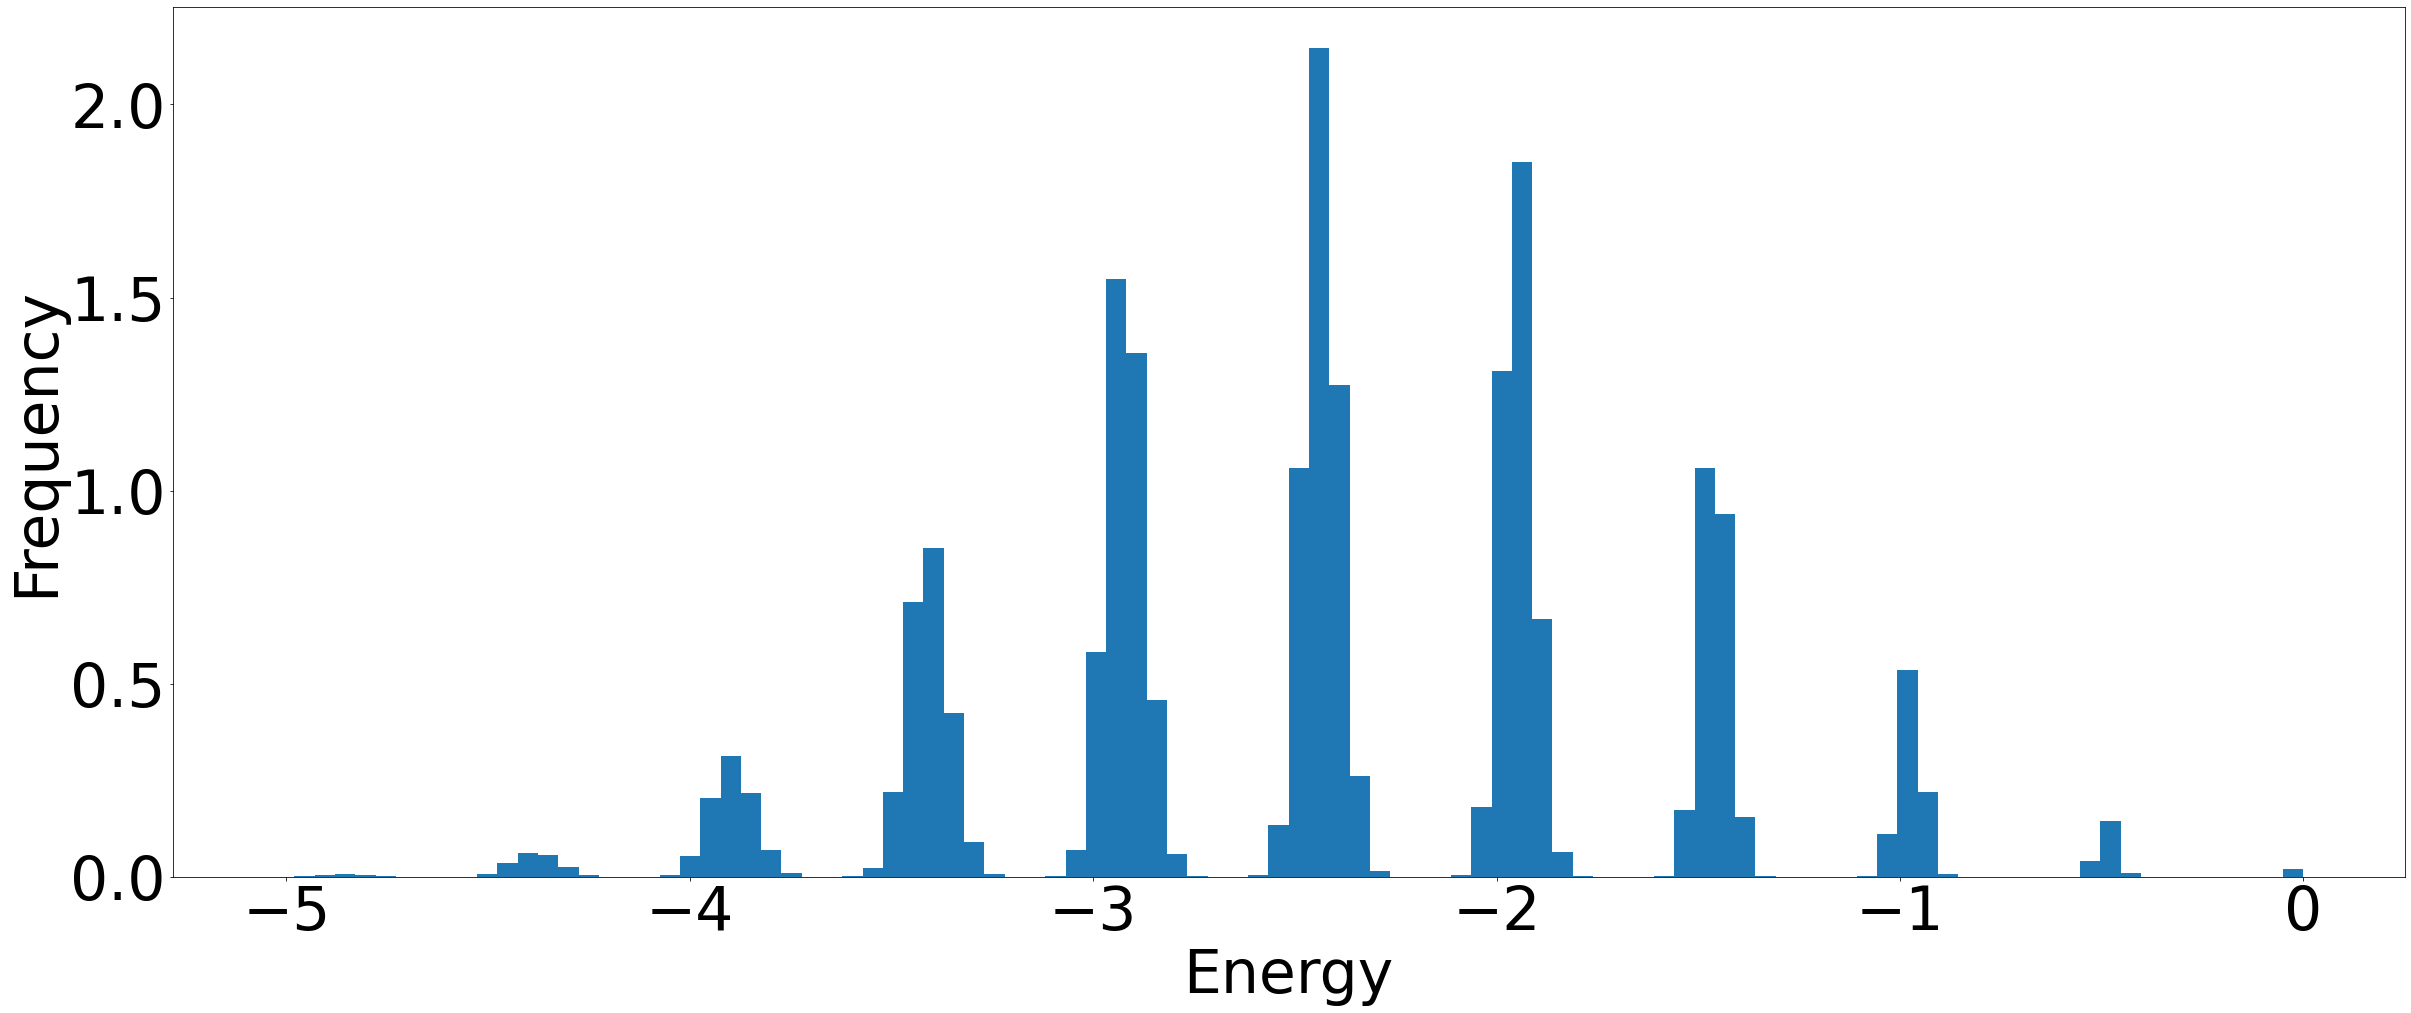

In [55]:
plot_sample_energies(rbm_energies)

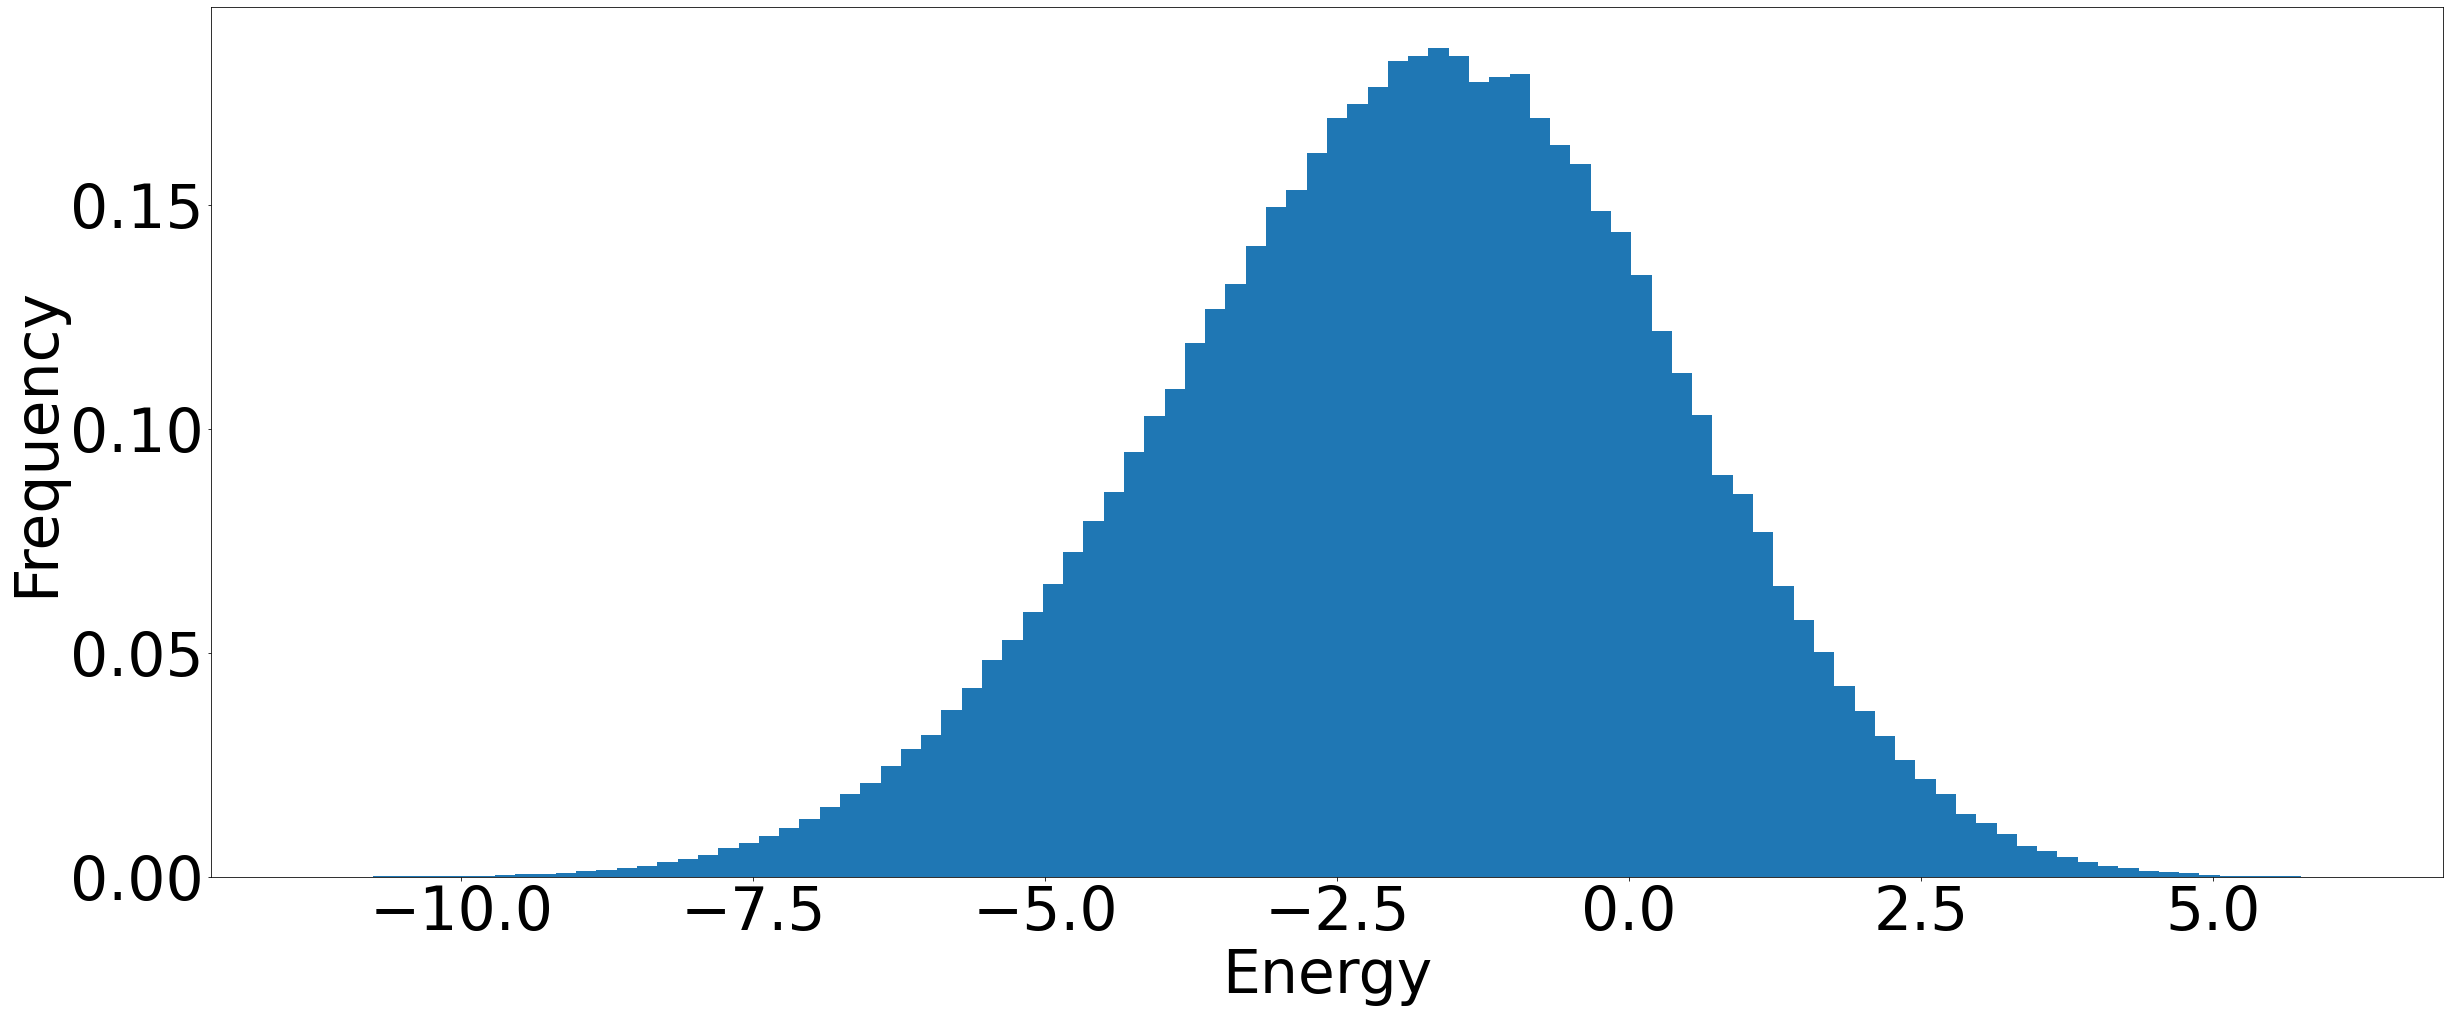

In [56]:
plot_sample_energies(crbm_energies)

In [57]:
def sample_probs(rbm, rbm_vis, rbm_hid):
    """
    Compute the probabilities of RBM configurations

    Returns:
        rbm_energy_exp : -vis^T W hid - a^T hid - b^T vis
    """
    # Broadcast W to (pcd_batchSize * nVis * nHid)
    w, vbias, hbias = rbm.weights, rbm.visible_bias, rbm.hidden_bias
    w = w + torch.zeros((rbm_vis.size(0),) + w.size(), device=rbm_vis.device)
    vbias = vbias.to(rbm_vis.device)
    hbias = hbias.to(rbm_hid.device)

    # Prepare H, V for torch.matmul()
    # Change V.size() from (batchSize * nVis) to (batchSize * 1 * nVis)
    vis = rbm_vis.unsqueeze(2).permute(0, 2, 1)
    # Change H.size() from (batchSize * nHid) to (batchSize * nHid * 1)
    hid = rbm_hid.unsqueeze(2)

    batch_energies = (- torch.matmul(vis, torch.matmul(w, hid)).reshape(-1) 
                      - torch.matmul(rbm_vis, vbias)
                      - torch.matmul(rbm_hid, hbias))
    
    batch_probs_unnorm = torch.exp(-batch_energies)
    batch_probs = batch_probs_unnorm/torch.sum(batch_probs_unnorm)
    return batch_probs

In [58]:
def plot_energy_vs_prob(energies, probs):
    """
    Plot a scatter plot of energies vs probabilities     
    """
    fig, ax = plt.subplots(figsize=(40, 16))
    
    ax.scatter(energies, probs)
    
    ax.set_xlabel("Energy", fontsize=60)
    ax.set_ylabel("Probability", fontsize=60)
    
    ax.tick_params(axis='both', which='major', labelsize=60)
    
    plt.show()
    plt.close()

In [59]:
def plot_weighted_energies(energies, probs):
    """
    Plot a histogram of the configuration energies weighted
    by their true probability
    """
    fig, ax = plt.subplots(figsize=(40, 16))
    
    ax.hist(energies*probs, bins=100, density=True)
    
    ax.set_xlabel("Energy", fontsize=60)
    ax.set_ylabel("Frequency", fontsize=60)
    
    ax.tick_params(axis='both', which='major', labelsize=60)
    
    plt.show()
    plt.close()

In [60]:
rbm_probs = sample_probs(rbm, config_tensor[:, :_NUM_NODES], config_tensor[:, _NUM_NODES:]).detach().cpu().numpy()
crbm_probs = sample_probs(crbm, config_tensor[:, :_NUM_NODES], config_tensor[:, _NUM_NODES:]).detach().cpu().numpy()

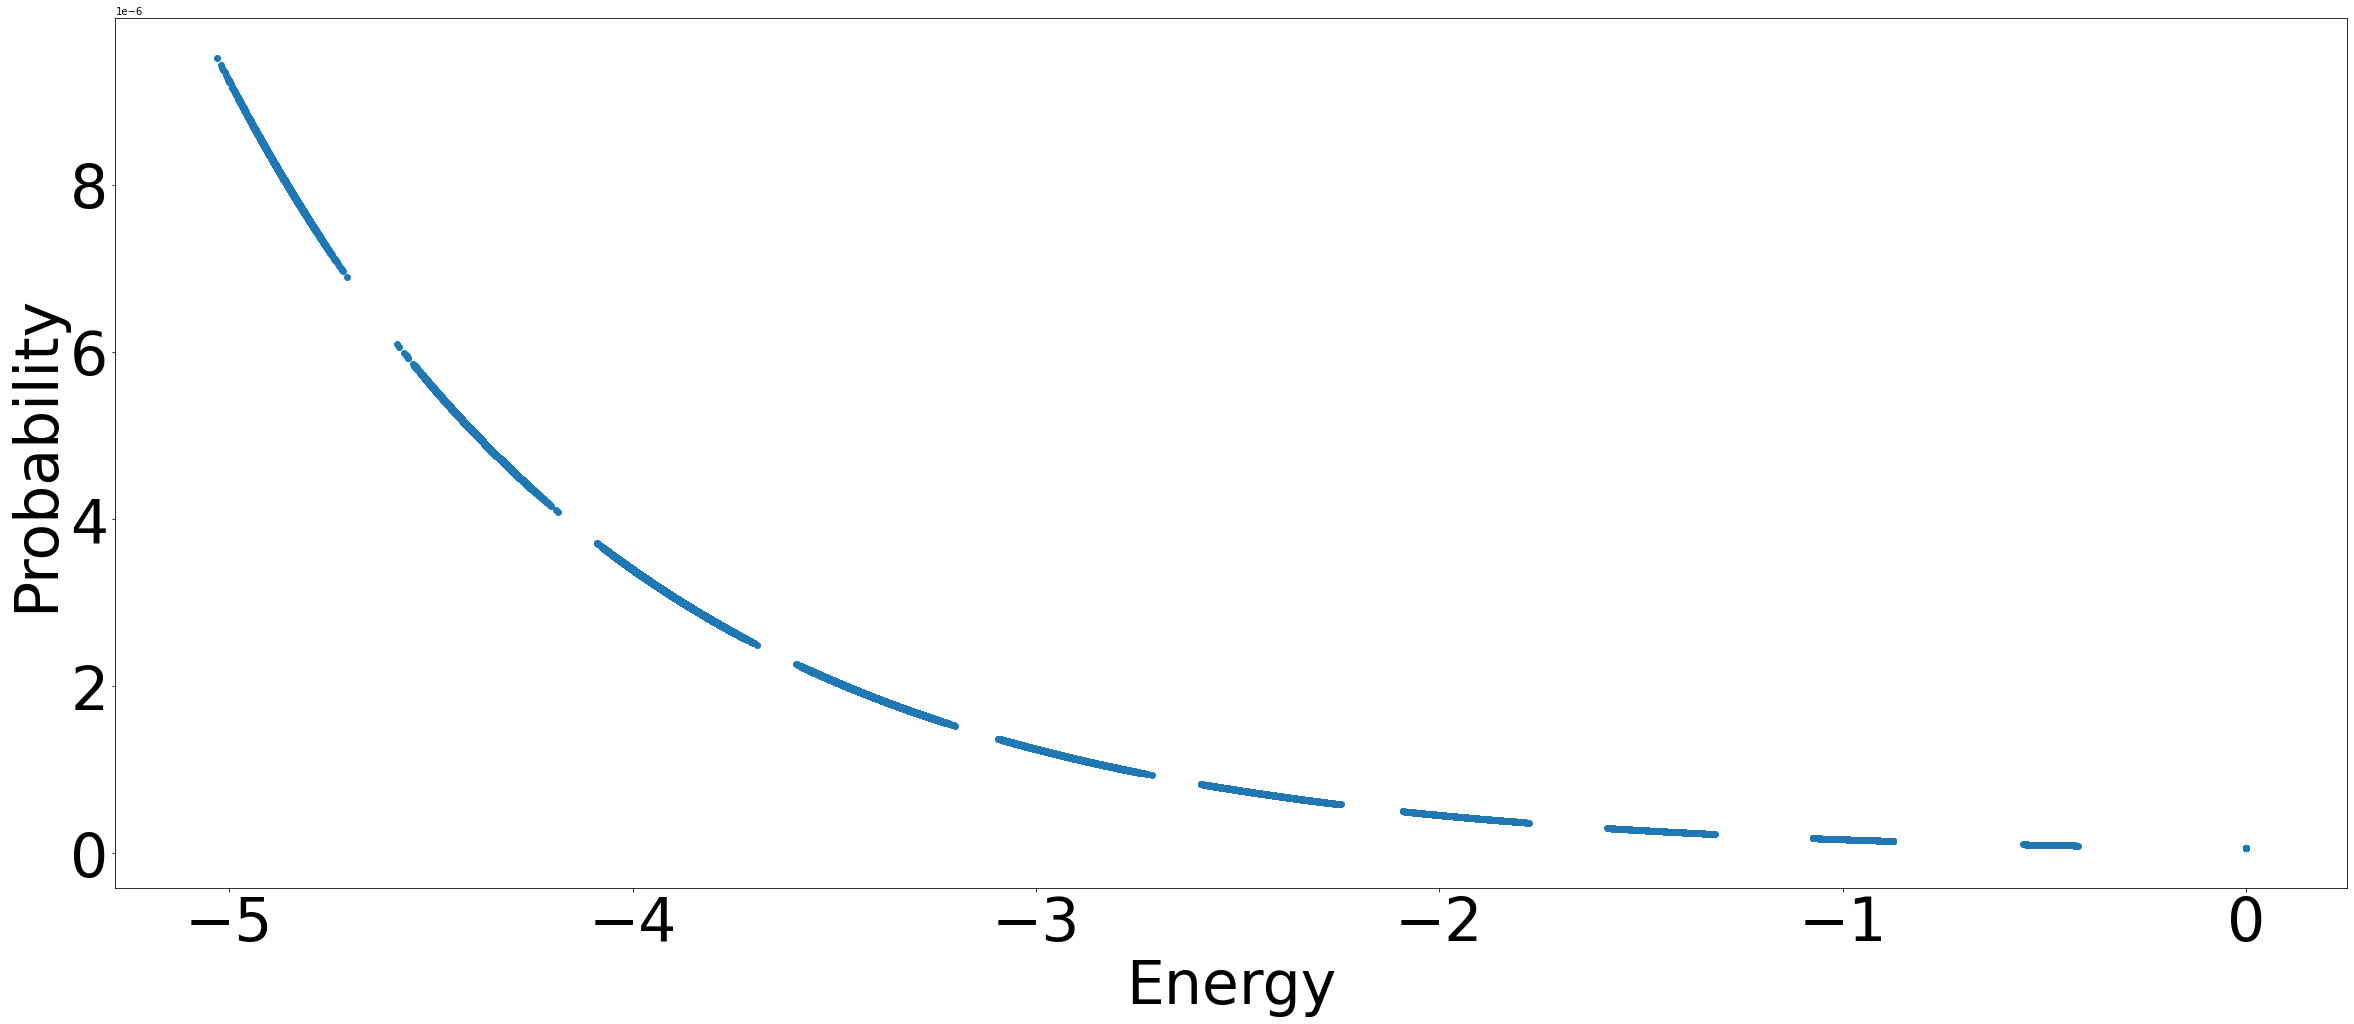

In [61]:
plot_energy_vs_prob(rbm_energies, rbm_probs)

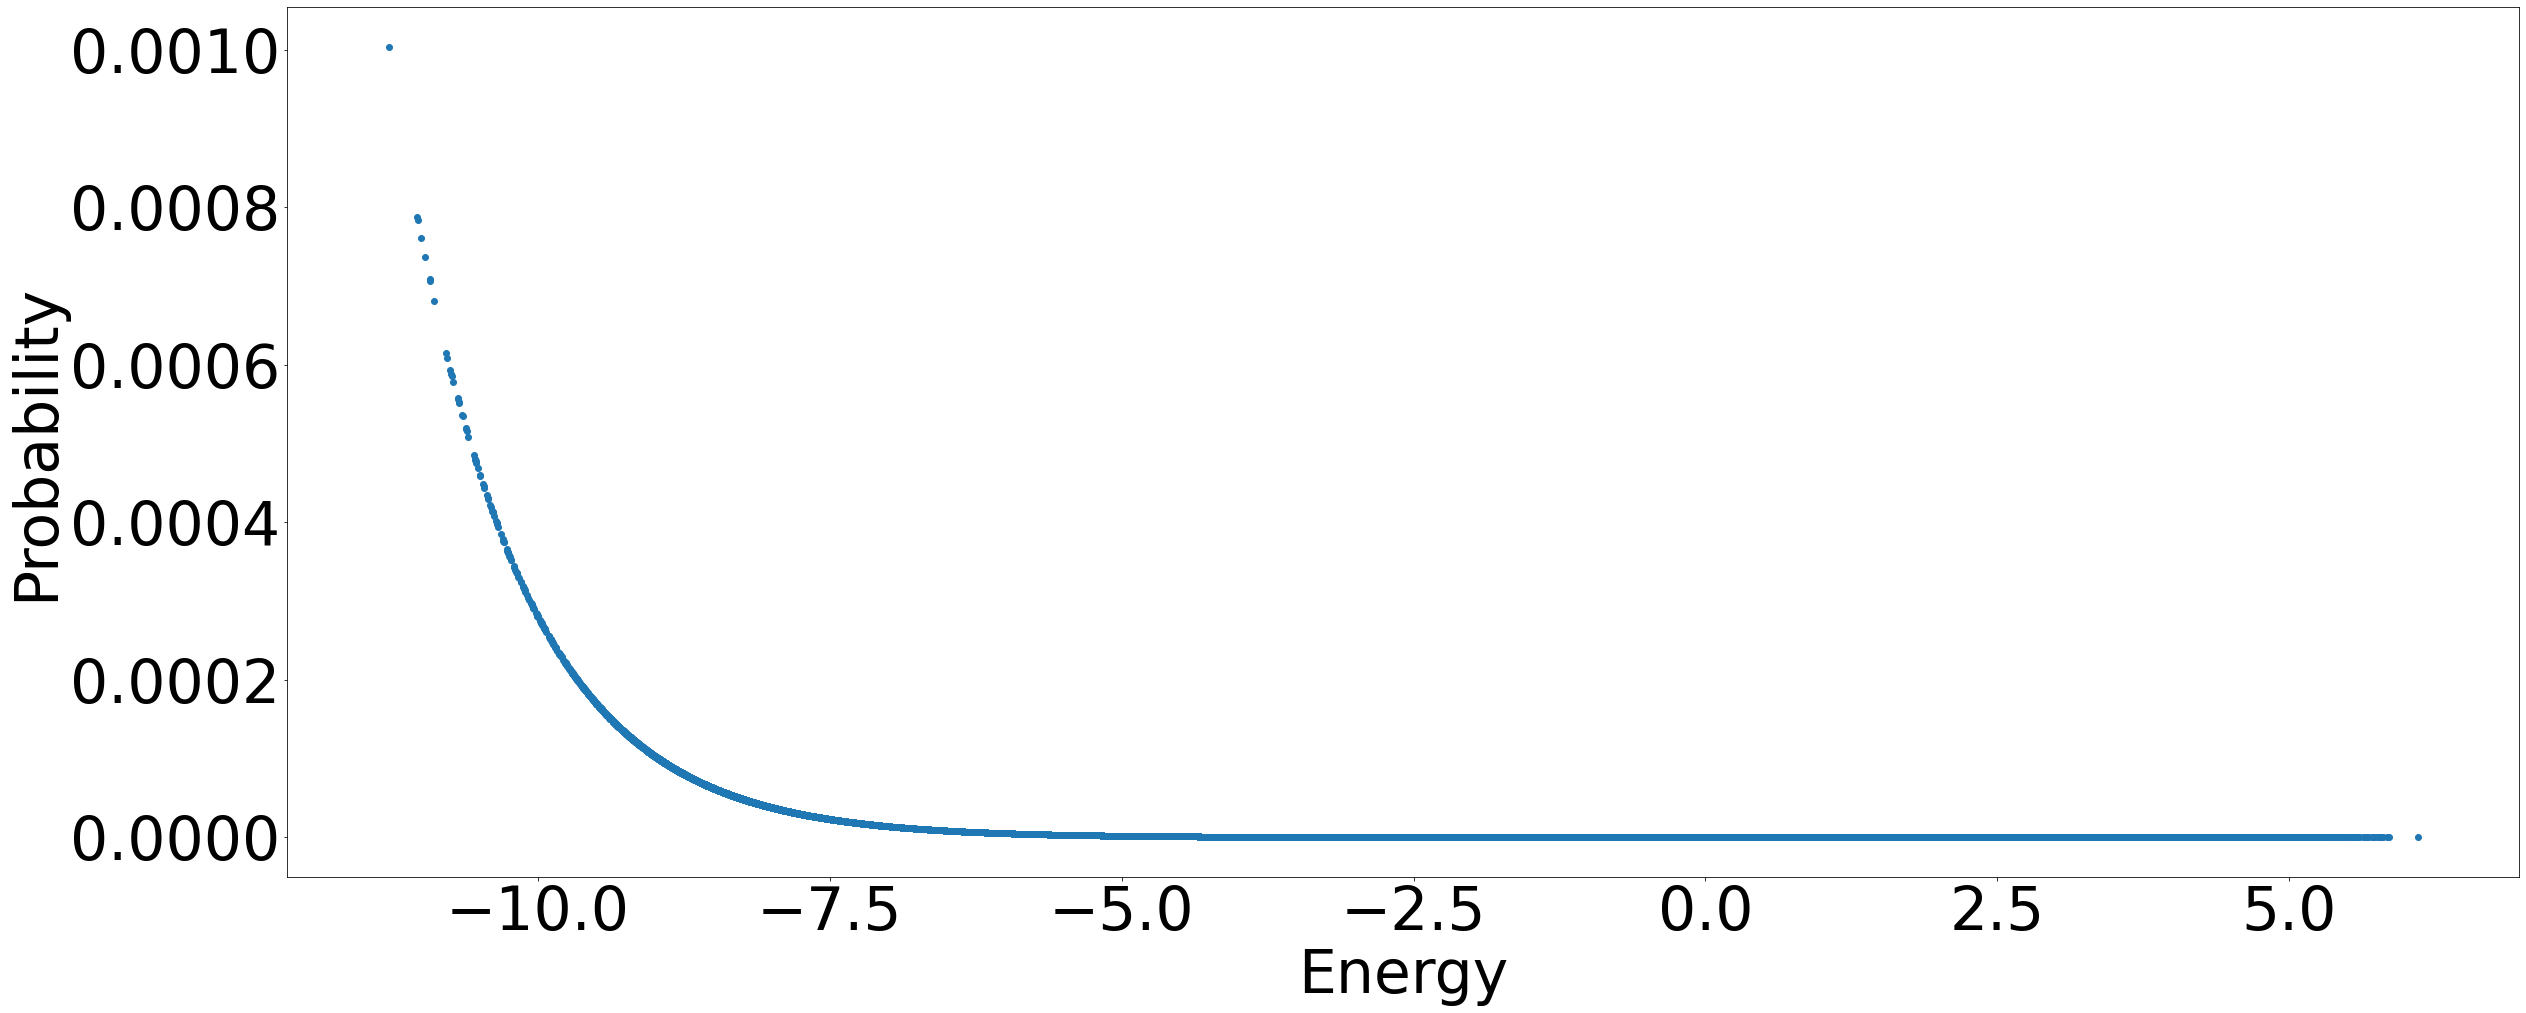

In [62]:
plot_energy_vs_prob(crbm_energies, crbm_probs)

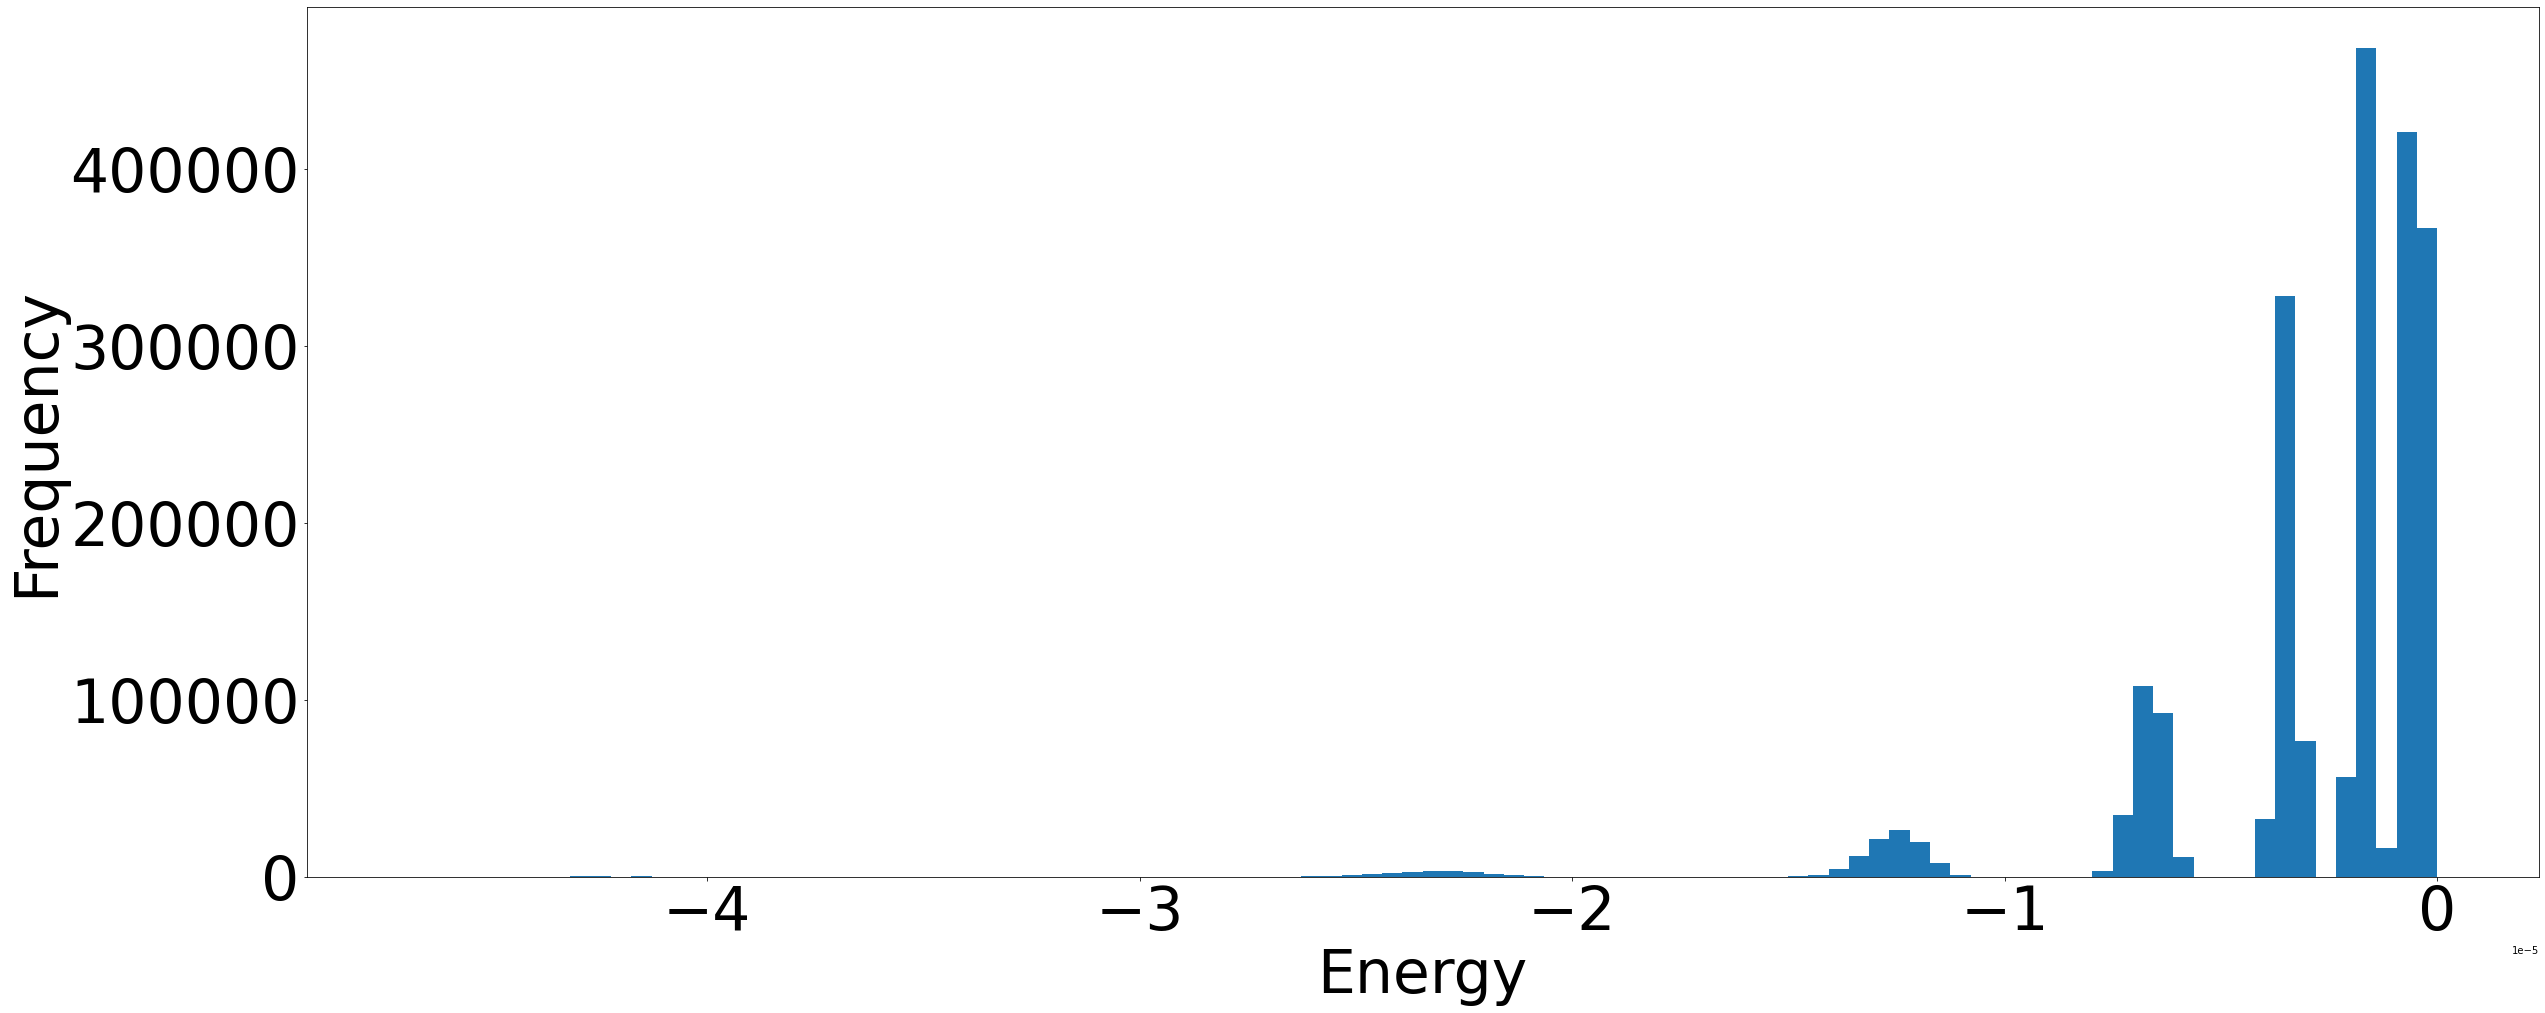

In [29]:
plot_weighted_energies(rbm_energies, rbm_probs)

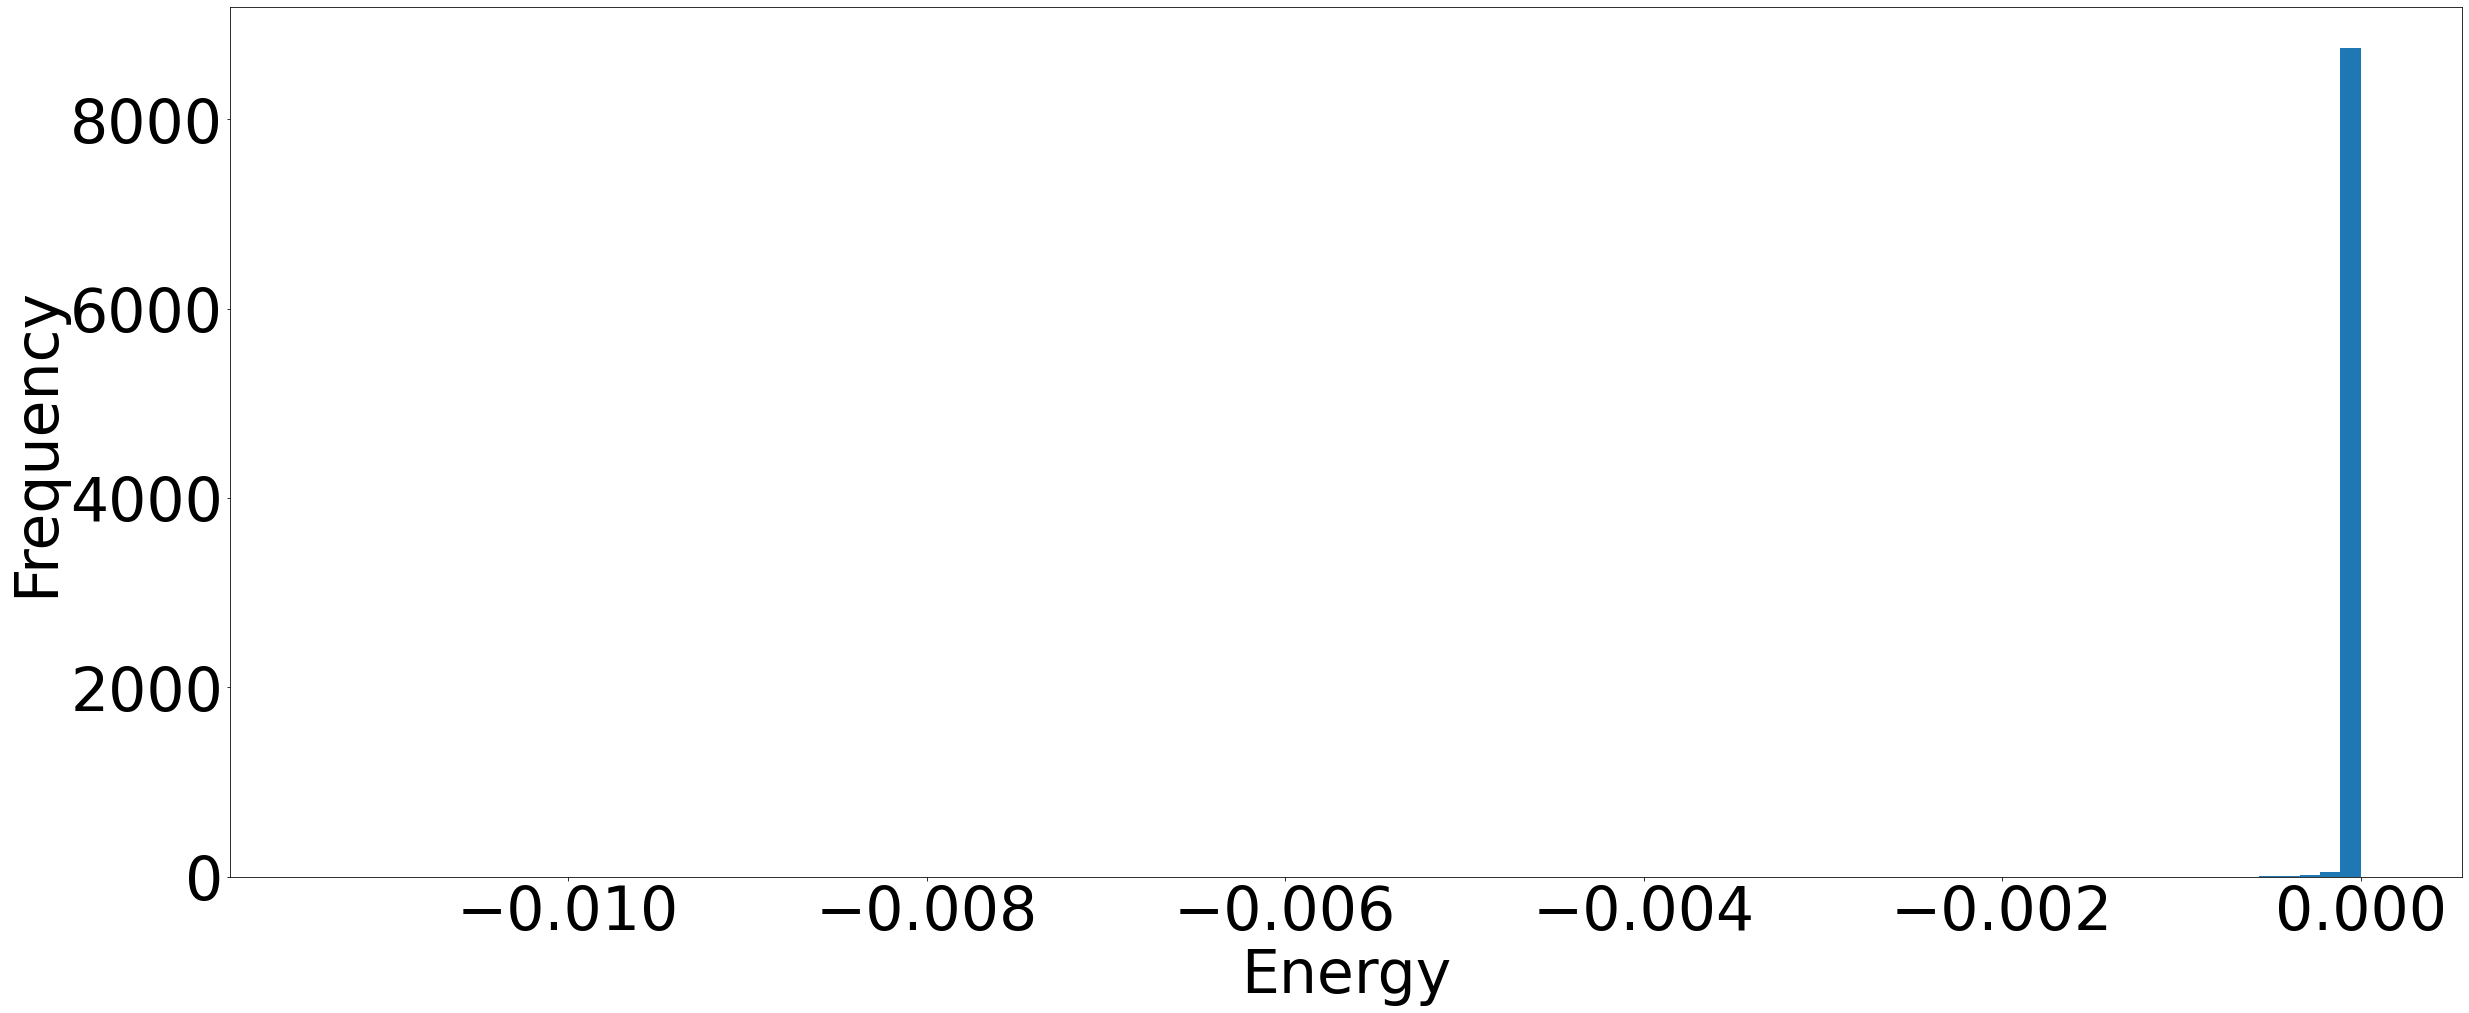

In [63]:
plot_weighted_energies(crbm_energies, crbm_probs)